# Mushroom classifier

In [1]:
import os
from PIL import Image
import random
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import torch
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torchvision.models.mobilenet import mobilenet_v3_large
from torchvision import transforms
import torch.utils.data as data

In [2]:
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

# Storing ID of the current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of the current CUDA device: {cuda_id}")

print(f"Name of the current CUDA device: {torch.cuda.get_device_name(cuda_id)}")

Is CUDA supported by this system? True
CUDA version: 11.7
ID of the current CUDA device: 0
Name of the current CUDA device: NVIDIA GeForce RTX 3070


## Read folder of folders of images

In [3]:
def read_images_folder(folder_path):
    """
    Read images from a specified folder path.

    Args:
        folder_path (str): The path of the folder containing the images.

    Returns:
        tuple: A tuple containing a list of images and a list of folder names.
    """
    images = []
    labels = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            if file.endswith(('.jpg', '.png')):
                image = read_image(file_path)
                if image is not None:
                    images.append(image)
                    folder_name = os.path.basename(root)
                    labels.append(folder_name)
    
    # convert labels to first character of labels
    labels = [int(label[0]) for label in labels]
    return images, labels

def read_image(file_path):
    """
    Read an image from a specified file path.

    Args:
        file_path (str): The path of the image file to be read.

    Returns:
        PIL.Image.Image or None: The opened image if successful, or None if an error occurs.

    """
    try:
        with Image.open(file_path) as image:
            return image.copy()
    except (IOError, SyntaxError) as e:
        print(f"Error opening image: {file_path} - {e}")
        return None

def convert_images_to_tensors(images):
    """
    Convert a list of images to tensors.

    Args:
        images (list): A list of PIL.Image.Image objects.

    Returns:
        list: A list of converted torch.Tensor objects.

    """
    tensor_images = []
    for image in images:
        tensor = ToTensor()(image)
        tensor_images.append(tensor)
    return tensor_images

In [4]:
images, labels = read_images_folder(folder_path = 'data')
tensor_images = convert_images_to_tensors(images)

C:\Users\Erik Konstenius\anaconda3\lib\site-packages\PIL\Image.py:2966: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


Error opening image: data\1_2_boletus_edulis\8a4622f48d5c7eb38ff0d09a519bd7b3.jpg - cannot identify image file 'data\\1_2_boletus_edulis\\8a4622f48d5c7eb38ff0d09a519bd7b3.jpg'
Error opening image: data\1_2_boletus_edulis\How-to-grow-porcini-at-home-for-beginners-640x480.jpg - cannot identify image file 'data\\1_2_boletus_edulis\\How-to-grow-porcini-at-home-for-beginners-640x480.jpg'
Error opening image: data\1_2_boletus_edulis\rare-edible-mushroom-boletus-edulis-cut-in-half-on-golden-chanterelle-yellow.jpg - cannot identify image file 'data\\1_2_boletus_edulis\\rare-edible-mushroom-boletus-edulis-cut-in-half-on-golden-chanterelle-yellow.jpg'
Error opening image: data\2_2_cantharellus_tubaeformis\72396584b99750155a9b44e94bbd5350.jpg - cannot identify image file 'data\\2_2_cantharellus_tubaeformis\\72396584b99750155a9b44e94bbd5350.jpg'
Error opening image: data\2_2_cantharellus_tubaeformis\craterellus-tubaeformis-or-cantharellus-tubaeformis-is-an-edible-fungus-also.jpg - cannot identify 

## Inspect images

In [5]:
print("Number of images: " + str(len(images)))

Number of images: 7880


In [6]:
def inspect_random_images(images, folders):
    """
    Display a grid of randomly selected images with their corresponding label.

    Args:
        images (list): A list of torch.Tensor objects representing the images.
        folders (list): A list of labels corresponding to the images.

    Returns:
        None

    """
    random_indices = random.sample(range(len(images)), 9)  # Select 9 random indices
    fig, axes = plt.subplots(3, 3, figsize=(8, 8))  # Create a 3x3 grid of subplots

    for i, ax in enumerate(axes.flatten()):
        index = random_indices[i]
        image_tensor = images[index]
        folder_name = folders[index]

        # Convert image tensor to a NumPy array
        image_np = image_tensor.permute(1, 2, 0).cpu().numpy()

        # Display the image
        ax.imshow(image_np)
        ax.set_title(folder_name)
        ax.axis('off')

    plt.tight_layout()  # Adjust subplot spacing
    plt.show()

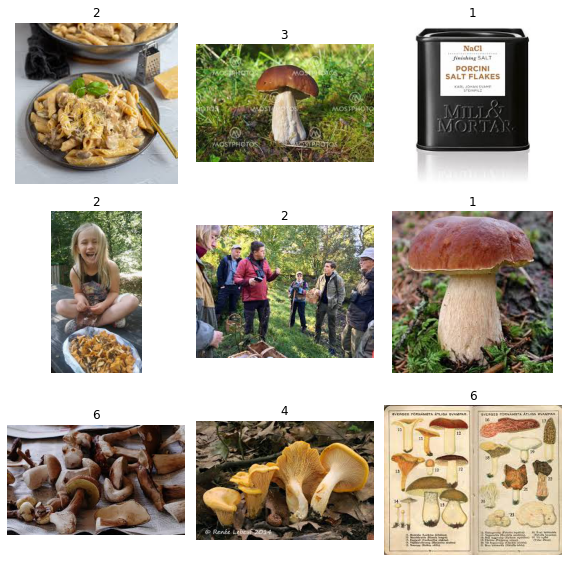

In [7]:
inspect_random_images(tensor_images, labels)

## Preprocess images

### Filter only images with three colour channels

In [8]:
def filter_tensors_with_three_channels(tensor_images, labels):
    """
    Filters a list of tensors to only include tensors with three channels.
    Removes labels with the same index as the images that have less than three channels.

    Args:
        tensor_images (list): A list of tensors.
        labels (list): A list of labels corresponding to the tensor images.

    Returns:
        tuple: A tuple containing two lists - the filtered tensors and filtered labels.
    """
    filtered_tensors = []
    filtered_labels = []
    for tensor, label in zip(tensor_images, labels):
        if tensor.shape[0] == 3:
            filtered_tensors.append(tensor)
            filtered_labels.append(label)
    return filtered_tensors, filtered_labels

In [9]:
tensor_images_3_channels, labels_3_channels = filter_tensors_with_three_channels(tensor_images, labels)

In [10]:
print("Number of images with three channels: " + str(len(tensor_images_3_channels)))

Number of images with three channels: 7737


### Filter out images where mean pixel value within an acceptable margin

In [11]:
def filter_tensors_with_threshold(tensor_images, labels, red_good, green_good, blue_good, acceptable_deviation):
    """
    Filters a list of tensors based on threshold criteria for average pixel values.
    Removes labels with the same index as the images that do not meet the threshold criteria.

    Args:
        tensor_images (list): A list of tensors.
        labels (list): A list of labels corresponding to the tensor images.
        red_good (float): Threshold for the average red pixel value.
        green_good (float): Threshold for the average green pixel value.
        blue_good (float): Threshold for the average blue pixel value.
        acceptable_deviation (float): Acceptable deviation from the thresholds.

    Returns:
        tuple: A tuple containing two lists - the filtered tensors and filtered labels.
    """
    filtered_tensors = []
    filtered_labels = []
    for tensor, label in zip(tensor_images, labels):
        red_avg = tensor[0].mean()
        green_avg = tensor[1].mean()
        blue_avg = tensor[2].mean()

        if (
            red_good - acceptable_deviation <= red_avg <= red_good + acceptable_deviation and
            green_good - acceptable_deviation <= green_avg <= green_good + acceptable_deviation and
            blue_good - acceptable_deviation <= blue_avg <= blue_good + acceptable_deviation
        ):
            filtered_tensors.append(tensor)
            filtered_labels.append(label)

    return filtered_tensors, filtered_labels


In [12]:
red_good = 82/255
green_good = 75/255
blue_good = 65/255
acceptable_deviation = 40/255

tensor_images_good_colours, labels_good_colours = filter_tensors_with_threshold(
    tensor_images_3_channels,
    labels_3_channels,
    red_good,
    green_good,
    blue_good,
    acceptable_deviation
)

In [13]:
print("Number of images: " + str(len(tensor_images_good_colours)))

Number of images: 3219


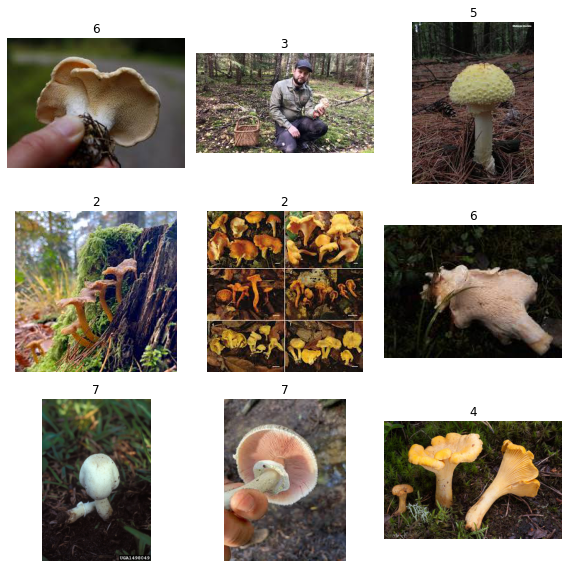

In [14]:
inspect_random_images(tensor_images_good_colours, labels_good_colours)

### Resize images

In [15]:
def resize_images(image_tensor_list):
    """
    Resize a list of image tensors to a specified size.

    Args:
        image_tensor_list (list): A list of torch.Tensor objects representing the images.

    Returns:
        list: A list of resized image tensors.

    """
    resized_images = []

    for image_tensor in image_tensor_list:
        image_tensor = F.interpolate(image_tensor.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False)
        image_tensor = image_tensor.squeeze(0)

        resized_images.append(image_tensor)

    return resized_images

In [16]:
# Resize the images
resized_images = resize_images(tensor_images_good_colours)

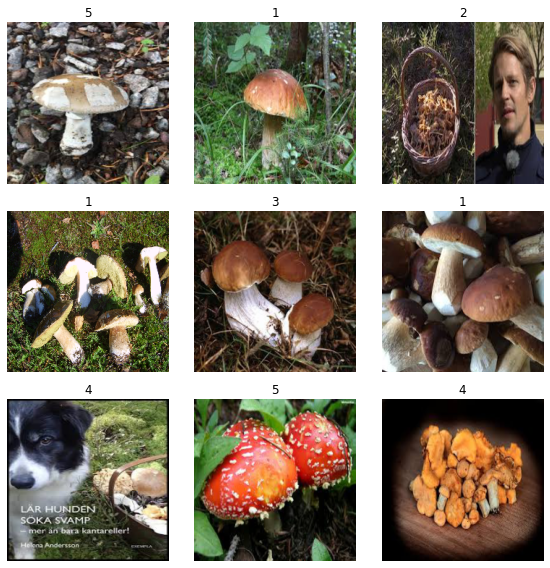

In [17]:
inspect_random_images(resized_images, labels_good_colours)

### Normalize images like Imagen

In [18]:
def normalize_mobilenetv3(images):
    """
    Normalize a list of images using the MobileNetV3 normalization values.

    Args:
        images (list): A list of input images.

    Returns:
        torch.Tensor: A tensor containing the normalized images.

    """
    preprocess = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    preprocessed_images = []
    for image in images:
        preprocessed_image = preprocess(image)
        preprocessed_images.append(preprocessed_image)

    input_tensor = torch.stack(preprocessed_images)
    return input_tensor

In [19]:
# Normalize according to Imagen
normalized_images = normalize_mobilenetv3(resized_images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


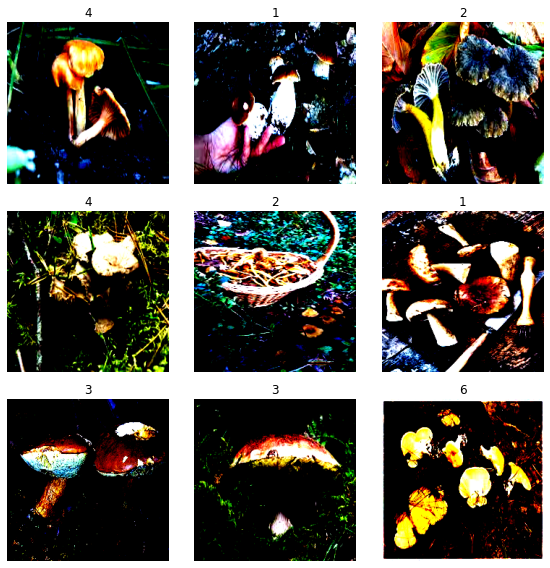

In [20]:
# Example usage
inspect_random_images(normalized_images, labels_good_colours)

## Preprocess labels

In [21]:
def one_hot_encode(labels):
    """
    Perform one-hot encoding on a list of categorical labels.

    Args:
        labels (list): A list of categorical labels.

    Returns:
        numpy.ndarray: An array of one-hot encoded labels.

    """
    # Convert the list of strings into numerical labels
    label_encoder = LabelEncoder()
    numerical_labels = label_encoder.fit_transform(labels)

    # Perform one-hot encoding
    onehot_encoder = OneHotEncoder(sparse=False)
    onehot_labels = onehot_encoder.fit_transform(numerical_labels.reshape(-1, 1))

    return onehot_labels

def tensor_converter(labels):
    """
    Convert a numpy array of one-hot encoded labels to a PyTorch tensor.

    Args:
        labels (numpy.ndarray): The one-hot encoded labels as a numpy array.

    Returns:
        torch.Tensor: The one-hot encoded labels as a PyTorch tensor.
    """
    return torch.from_numpy(labels)


In [37]:
one_hot_encoded_labels = one_hot_encode(labels_good_colours)
labels_tensor = tensor_converter(one_hot_encoded_labels)


## Split into training and test set

In [46]:
from sklearn.model_selection import train_test_split

def split_dataset(images_tensor, labels_tensor, test_size=0.2, random_state=42):
    # Get the number of samples
    num_samples = images_tensor.shape[0]

    # Generate indices for train and test sets
    indices = torch.arange(num_samples)
    indices_train, indices_test = train_test_split(
        indices, test_size=test_size, random_state=random_state
    )

    # Split the tensors into train and test sets using the indices
    images_tensor_train = images_tensor[indices_train]
    labels_tensor_train = labels_tensor[indices_train]
    images_tensor_test = images_tensor[indices_test]
    labels_tensor_test = labels_tensor[indices_test]

    return images_tensor_train, labels_tensor_train, images_tensor_test, labels_tensor_test

In [51]:
images_train, labels_train, images_test, labels_test = split_dataset(normalized_images, labels_tensor)

print("Train set shapes:")
print(images_train.shape)
print(labels_train.shape)
print("Test set shapes:")
print(images_test.shape)
print(labels_test.shape)

Train set shapes:
torch.Size([2575, 3, 224, 224])
torch.Size([2575, 7])
Test set shapes:
torch.Size([644, 3, 224, 224])
torch.Size([644, 7])


## Train model

This project uses the MobileNetV3 architecture. MobileNetV3 is a convolutional neural network architecture designed for efficient and accurate image classification on mobile and embedded devices. It introduces several novel features, including the use of a combination of depthwise separable convolutions and linear bottlenecks to reduce computation while preserving model capacity. It also incorporates a hard sigmoid activation function to improve efficiency and employs multiple inverted residual blocks with squeeze-and-excitation modules for better feature representation. MobileNetV3 achieves state-of-the-art performance on image classification tasks while maintaining a small model size and low latency, making it ideal for resource-constrained devices.

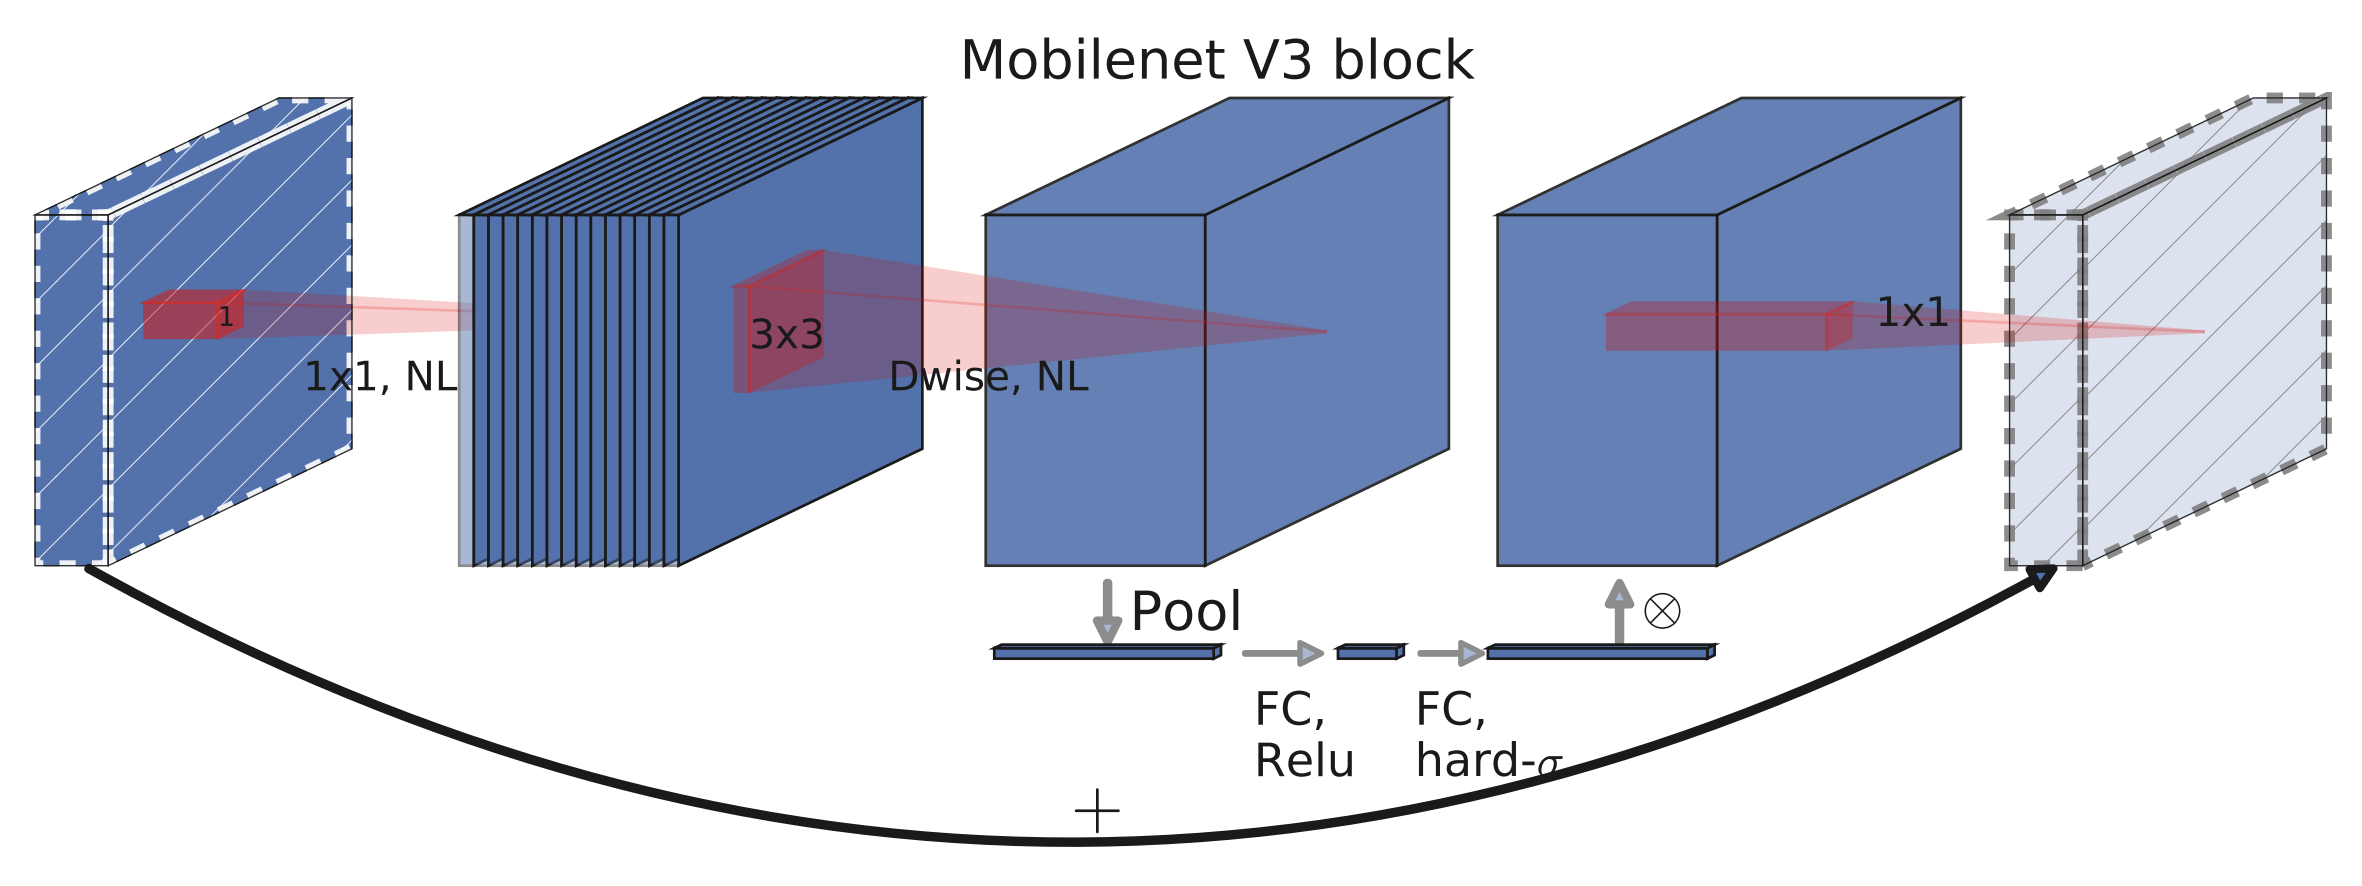

In [ ]:
def create_dataloader(images, labels, batch_size=32, shuffle=True):
    """
    Create a DataLoader for batching and shuffling the data.

    Args:
        images (torch.Tensor): A tensor containing the images.
        labels (torch.Tensor): A tensor containing the labels.
        batch_size (int, optional): The batch size. Defaults to 32.
        shuffle (bool, optional): Whether to shuffle the data. Defaults to True.

    Returns:
        torch.utils.data.DataLoader: The created DataLoader.

    """
    
    # Convert to tensor dataset
    dataset = data.TensorDataset(images, labels)
    dataloader = data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

In [ ]:
# Construct data loader object
train_dataloader = create_dataloader(images_train, labels_train, batch_size=32, shuffle=True)
test_dataloader = create_dataloader(images_test, labels_test, batch_size=32, shuffle=False)

In [58]:
def initialize_model(num_classes):
    """
    Initialize a MobileNetV3-Large model with ImageNet weights and replace the last
    classification layer.

    Args:
        num_classes (int): The number of output classes for the model.

    Returns:
        torch.nn.Module: The initialized and modified MobileNetV3-Large model.

    """
    # Initialize MobileNetV3-Large model with ImageNet weights
    model = mobilenet_v3_large(pretrained=True)
    
    # Replace the last classification layer
    num_features = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(num_features, num_classes)
    
    return model

In [59]:
# Set device settings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Initiating training on " + str(device))

# Initialize the model
model = initialize_model(num_classes = len(np.unique(labels)))

Initiating training on cuda


C:\Users\Erik Konstenius\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Erik Konstenius\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [71]:
def train(model, train_dataloader, test_dataloader, num_epochs, device):
    """
    Train a model using the provided dataloader for the specified number of epochs.

    Args:
        model (torch.nn.Module): The model to be trained.
        train_dataloader (torch.utils.data.DataLoader): The dataloader containing the training data.
        test_dataloader (torch.utils.data.DataLoader): The dataloader containing the test data.
        num_epochs (int): The number of epochs to train the model.
        device (torch.device): The device to be used for training.

    Returns:
        torch.nn.Module: The trained model.
        list: List of training losses per epoch.
        list: List of test losses per epoch.

    """

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

    model = model.to(device)
    model.train()

    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        train_loss = 0.0
        test_loss = 0.0
        
        # Training
        model.train()
        for inputs, targets in train_dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)

        # Evaluation
        model.eval()
        with torch.no_grad():
            for inputs, targets in test_dataloader:
                inputs = inputs.to(device)
                targets = targets.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, targets)
                test_loss += loss.item()

        test_loss /= len(test_dataloader)
        test_losses.append(test_loss)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Test Loss: {test_loss:.4f}")

    return model, train_losses, test_losses

In [72]:
# Train and evaluate the model
trained_model, train_losses, test_losses = train(model, train_dataloader, test_dataloader, num_epochs=30, device=device)

Epoch 1/30 - Train Loss: 0.3167 - Test Loss: 0.9037
Epoch 2/30 - Train Loss: 0.3182 - Test Loss: 0.9042
Epoch 3/30 - Train Loss: 0.3076 - Test Loss: 0.9077
Epoch 4/30 - Train Loss: 0.2969 - Test Loss: 0.9098
Epoch 5/30 - Train Loss: 0.2911 - Test Loss: 0.9156
Epoch 6/30 - Train Loss: 0.2938 - Test Loss: 0.9159
Epoch 7/30 - Train Loss: 0.2875 - Test Loss: 0.9180
Epoch 8/30 - Train Loss: 0.2864 - Test Loss: 0.9201
Epoch 9/30 - Train Loss: 0.2873 - Test Loss: 0.9226
Epoch 10/30 - Train Loss: 0.2838 - Test Loss: 0.9251
Epoch 11/30 - Train Loss: 0.2785 - Test Loss: 0.9280
Epoch 12/30 - Train Loss: 0.2694 - Test Loss: 0.9295
Epoch 13/30 - Train Loss: 0.2622 - Test Loss: 0.9325
Epoch 14/30 - Train Loss: 0.2702 - Test Loss: 0.9320
Epoch 15/30 - Train Loss: 0.2672 - Test Loss: 0.9352
Epoch 16/30 - Train Loss: 0.2539 - Test Loss: 0.9383
Epoch 17/30 - Train Loss: 0.2546 - Test Loss: 0.9430
Epoch 18/30 - Train Loss: 0.2494 - Test Loss: 0.9447
Epoch 19/30 - Train Loss: 0.2464 - Test Loss: 0.9494
Ep

In [73]:
def plot_training_progress(train_losses, test_losses):
    """
    Plot the training progress on the train set and the test set per epoch.

    Args:
        train_losses (list): List of training losses per epoch.
        test_losses (list): List of test losses per epoch.

    Returns:
        None.

    """

    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, test_losses, label='Test Loss')
    plt.title('Training Progress')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

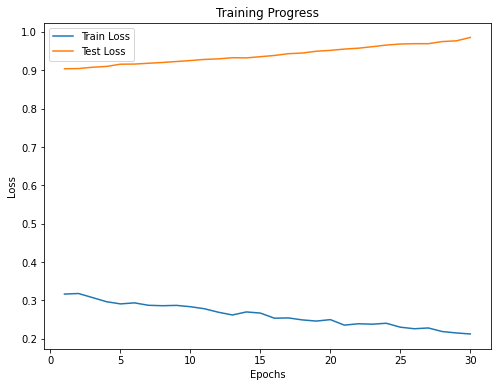

In [74]:
plot_training_progress(train_losses, test_losses)

In [75]:
def evaluate(model, dataloader, device):
    """
    Evaluate a trained model using the provided dataloader.

    Args:
        model (torch.nn.Module): The trained model to be evaluated.
        dataloader (torch.utils.data.DataLoader): The dataloader containing the evaluation data.
        device (torch.device): The device to be used for evaluation.

    Returns:
        float: Accuracy of the model on the evaluation data.
        float: Precision of the model on the evaluation data.
        float: Recall of the model on the evaluation data.
        float: F1-score of the model on the evaluation data.
        torch.Tensor: Confusion matrix of the model predictions.

    """
    model = model.to(device)
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(targets.tolist())
            y_true_indices = np.argmax(y_true, axis=1).tolist()
            y_pred.extend(predicted.tolist())

    accuracy = accuracy_score(y_true_indices, y_pred)
    precision = precision_score(y_true_indices, y_pred, average='macro')
    recall = recall_score(y_true_indices, y_pred, average='macro')
    f1 = f1_score(y_true_indices, y_pred, average='macro')
    confusion_mat = confusion_matrix(y_true_indices, y_pred)

    return accuracy, precision, recall, f1, confusion_mat

In [76]:
accuracy, precision, recall, f1, confusion_mat = evaluate(trained_model, test_dataloader, device)

print(f"Accuracy: {accuracy}%")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
#print("Confusion Matrix:")
#print(confusion_mat)

Accuracy: 0.6909937888198758%
Precision: 0.6900037201441142
Recall: 0.6835683413867273
F1-score: 0.6850787770079065
